<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/2.1-CNNB32-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Layer CNN x 32 Filters (balanced weights)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib
import json

import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

RSTATE = 1
# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(RSTATE)
random.seed(RSTATE)
np.random.seed(RSTATE)


logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()



DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"

SAMPLE_SIZE = "200k"

LEARNING_RATE = 0.01
# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE = 3
PATIENCE = 4
PLATEAU_PATIENCE = 2
BALANCE_CLASS_WEIGHTS = True
MODEL_VERSION = 1
ENVIRONMENT = "2.1-CNNB32-prototype.ipynb"


# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 20
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100

DEBUG = False

MODEL_NAME = f"CNNB{FILTER1}"
ARCHITECTURE = f"1x{FILTER1}"
FEATURE_SET_NAME = "embedding_random"
REPORT_FILE = "dl_prototype-report.csv"
if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  REPORT_FILE = f'test-{REPORT_FILE}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLE_SIZE}-with_stop_nonlemmatized-preprocessed.csv"

ku.ModelWrapper.set_report_filename(REPORT_FILE)

directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"1 Layer CNN with {FILTER1} filters, kernel size {KERNEL_SIZE} (balanced weights)"





start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv(f"{DATA_FILE}")

In [4]:
df.head()

,star_rating,helpful_votes,total_votes,review_headline_orig,review_headline,review_body_orig,review_body,review_date
0,3,0,0,love polka dots,love polka dots,Best quality,best quality,2015-08-31
1,5,0,0,Five Stars,five stars,Very good quality for the price.,very good quality for the price,2015-08-31
2,5,0,0,but the case works great. Fits great and very ...,but the case works great fits great and very slim,I wish the bottom and top edges were a little ...,i wish the bottom and top edges were a little ...,2015-08-31
3,5,0,0,Perfect,perfect,Just finished using it while on a trip. Loved ...,just finished using it while on a trip loved b...,2015-08-31
4,1,0,0,cheaply made!,cheaply made,low quality earbuds! They do not stay in the e...,low quality earbuds they do not stay in the ea...,2015-08-31


In [0]:
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [6]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
print(y.shape)

(199538,)
<class 'pandas.core.series.Series'>
(199538, 5)


In [7]:


t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews)


reviews_sequences = t.texts_to_sequences(reviews)
reviews_padded = sequence.pad_sequences(reviews_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


X_train, X_test, y_train, y_test = train_test_split(reviews_padded, y, random_state=RSTATE)

Vocabulary size=57429
Number of Documents=199538


# Build our Model

In [0]:
model = Sequential()
model.add(Embedding(len(t.word_counts)+1, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=FILTER1, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=LEARNING_RATE), 
              metrics=['categorical_accuracy'])


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          17229000  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               400250    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1255      
Total params: 17,659,337
Trainable params: 17,659,337
Non-trainable params: 0
____________________________________________

In [10]:
# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PATIENCE, 
                           verbose=1, 
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
weights_dict = {i: weights[i] for i in np.arange(0, len(weights))}
print(f'class weights: {weights}')
print(f'class weights_dict: {weights_dict}')


mw = ku.ModelWrapper(model, 
                     model_name = MODEL_NAME, 
                     architecture = ARCHITECTURE,
                     feature_set_name = FEATURE_SET_NAME,
                     label_column = LABEL_COLUMN, 
                     feature_column = REVIEW_COLUMN,
                     data_file = DATA_FILE,
                     sample_size_str = SAMPLE_SIZE, 
                     tokenizer=t,
                     description=DESCRIPTION,
                     batch_size = BATCH_SIZE,
                     model_version = MODEL_VERSION,
                     save_dir = DRIVE_DIR)

mw.add("environment", ENVIRONMENT)
mw.add("patience", PATIENCE)
mw.add("plateau_patience", PLATEAU_PATIENCE)
mw.add("embed_size", EMBED_SIZE)
mw.add("filters", FILTER1)
mw.add("kernel_size", KERNEL_SIZE)



network_history = mw.fit(X_train, y_train,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      balance_class_weights = True,
                      callbacks=[early_stop, reduce_lr])

INFO:util.keras_util:saved file basename: CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1
INFO:util.keras_util:Creating drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/1
INFO:util.keras_util:Number of training examples: 149653


class weights: [1.43769724 3.07691596 2.18277088 1.19627098 0.37238702]
class weights_dict: {0: 1.4376972404351898, 1: 3.076915959907479, 2: 2.182770880052508, 3: 1.1962709832134293, 4: 0.372387022124348}


INFO:util.keras_util:Computed class weight dictionary: {0: 1.4389711538461538, 1: 3.073903666427031, 2: 2.1801005171534706, 3: 1.1976072343149808, 4: 0.3722942969090118}
INFO:util.keras_util:Adding checkpoint callback...
INFO:util.keras_util:model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa341bcc780>


Epoch 1/20
936/936 [==============================] - ETA: 0s - loss: 1.3107 - categorical_accuracy: 0.4868
Epoch 00001: val_loss improved from inf to 1.13249, saving model to drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 158s 169ms/step - loss: 1.3107 - categorical_accuracy: 0.4868 - val_loss: 1.1325 - val_categorical_accuracy: 0.5288 - lr: 0.0100
Epoch 2/20
936/936 [==============================] - ETA: 0s - loss: 1.1593 - categorical_accuracy: 0.5435
Epoch 00002: val_loss improved from 1.13249 to 1.10682, saving model to drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 155s 165ms/step - loss: 1.1593 - categorical_accuracy: 0.5435 - val_loss: 1.1068 - val_categorical_accuracy: 0.5521 - lr: 0.0100
Epoch 3/20
936/936 [==============================] - ETA: 0s - loss: 1.0945 - categorical_accuracy: 0.5674
Epoch 00003: val_loss improved from 1.10682 to 1.06819, saving model to drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 152s 162ms/step - loss: 1.0945 - categorical_accuracy: 0.5674 - val_loss: 1.0682 - val_categorical_accuracy: 0.5226 - lr: 0.0100
Epoch 4/20
936/936 [==============================] - ETA: 0s - loss: 1.0586 - categorical_accuracy: 0.5808
Epoch 00004: val_loss improved from 1.06819 to 1.02997, saving model to drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints
INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/checkpoints/assets


936/936 [==============================] - 151s 161ms/step - loss: 1.0586 - categorical_accuracy: 0.5808 - val_loss: 1.0300 - val_categorical_accuracy: 0.5566 - lr: 0.0100
Epoch 5/20
936/936 [==============================] - ETA: 0s - loss: 1.0183 - categorical_accuracy: 0.5924
Epoch 00005: val_loss did not improve from 1.02997
936/936 [==============================] - 149s 159ms/step - loss: 1.0183 - categorical_accuracy: 0.5924 - val_loss: 1.0587 - val_categorical_accuracy: 0.5453 - lr: 0.0100
Epoch 6/20
936/936 [==============================] - ETA: 0s - loss: 0.9984 - categorical_accuracy: 0.5987
Epoch 00006: val_loss did not improve from 1.02997
936/936 [==============================] - 148s 159ms/step - loss: 0.9984 - categorical_accuracy: 0.5987 - val_loss: 1.1915 - val_categorical_accuracy: 0.4064 - lr: 0.0100
Epoch 7/20
936/936 [==============================] - ETA: 0s - loss: 0.9628 - categorical_accuracy: 0.6132
Epoch 00007: val_loss did not improve from 1.02997
936/936

In [11]:
scores = mw.evaluate(X_test, y_test)
print("Test Accuracy: %.2f%%" % (mw.test_scores[1]*100))
print("Train Accuracy: %.2f%%" % (mw.train_scores[1]*100))
print(f'Overall Score: {ru.calculate_metric(mw.test_crd)}')

mw.save(append_report=True)


Number of test: 49885
Running model.evaluate on test set...
1559/1559 [==============================] - 5s 3ms/step - loss: 1.0362 - categorical_accuracy: 0.5544
Running model.predict on test set...
Unencode test set predictions...
Generating test set confusion matrix...
Calculating test set ROC AUC...
(49885, 5)
Getting test set classification report...
Running model.evaluate on training set...
4677/4677 [==============================] - 14s 3ms/step - loss: 0.8714 - categorical_accuracy: 0.6201
Running model.predict on training set...
Unencode training set predictions...
Generating training set confusion matrix...
Calculating training set ROC AUC...
(149653, 5)
Getting training set classification report...


INFO:util.report_util:calculating metric from dictionary
INFO:util.report_util:got all values to calculate
INFO:util.keras_util:saved file basename: CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1


Test Accuracy: 55.44%
Train Accuracy: 62.01%
Overall Score: 0.4325665774817775
Saving to report file: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/dl_prototype-report.csv
Saving report file...
Saving json config file: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1-weights.h5
Saving model file: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1-model.h5
Saving SavedModel to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-re

INFO:tensorflow:Assets written to: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/1/assets
INFO:util.keras_util:Saving tokenizer file: drive/My Drive/Springboard/capstone/models/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1/CNNB32-1x32-embedding_random-sampling_none-200k-review_body-v1-tokenizer.pkl


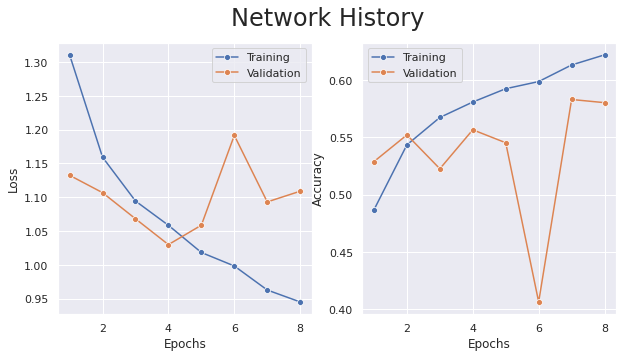


Confusion Matrix
[[ 2631  3174   964   114    75]
 [  338  1573  1128   141    53]
 [  114  1090  2449   591   310]
 [   24   510  2826  2187  2821]
 [   68   550  3014  4324 18816]]

Classification Report
              precision    recall  f1-score   support

           1       0.83      0.38      0.52      6958
           2       0.23      0.49      0.31      3233
           3       0.24      0.54      0.33      4554
           4       0.30      0.26      0.28      8368
           5       0.85      0.70      0.77     26772

    accuracy                           0.55     49885
   macro avg       0.49      0.47      0.44     49885
weighted avg       0.66      0.55      0.58     49885



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

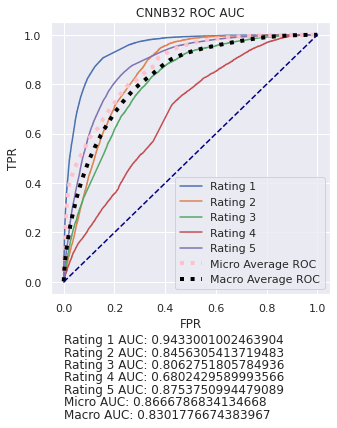

In [12]:




pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.test_confusion_matrix)

print("\nClassification Report")
print(mw.test_classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.test_roc_auc, mw.test_fpr, mw.test_tpr)



### Test that we can load the model back

In [13]:
from tensorflow.keras.models import load_model

model_loaded = load_model(mw.model_file)
scores = model_loaded.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

# this takes too long for real models
if DEBUG == True:
  y_predict = model_loaded.predict(X_test)
  y_predict_unencoded = ku.unencode(y_predict)
  y_test_unencoded = ku.unencode(y_test)

  # classification report
  print(classification_report(y_test_unencoded, y_predict_unencoded))

  # confusion matrix
  print(confusion_matrix(y_test_unencoded, y_predict_unencoded))


1559/1559 [==============================] - 5s 3ms/step - loss: 1.0362 - categorical_accuracy: 0.5544
Accuracy: 55.44%


In [14]:
end_time = datetime.now()
print(f'Start Time: {start_time}\n' \
      f'End Time: {end_time}\n' \
      f'Total Duration: {round((end_time - start_time).total_seconds() / 60, 2)} mins')
print(datetime.now())

Start Time: 2020-05-15 06:43:21.061367
End Time: 2020-05-15 07:05:18.504905
Total Duration: 21.96 mins
2020-05-15 07:05:18.505251
